In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sofware.data_collector import get_stock_data
from sofware.data_processor import process_data
from sofware.tasks import run_back_test
import mplfinance as mpf

%matplotlib inline
sns.set_style('darkgrid')

In [2]:
# how can we add the hour ?
start_date = "2024-10-11 09:30:00"
end_date = "2024-10-11 16:00:00"
period = "1d"
ticker = "MSFT"
interval = "1m"
initial_cash = 1000

In [3]:
data = get_stock_data(ticker=ticker, period=period, save_to_csv=True, interval=interval)
print(data)

Data saved to data/raw/MSFT_1d.csv
                                 Open        High         Low       Close  \
Datetime                                                                    
2024-10-11 09:30:00-04:00  415.910004  416.000000  414.174988  414.679993   
2024-10-11 09:31:00-04:00  414.470001  414.890015  414.150391  414.269989   
2024-10-11 09:32:00-04:00  414.260010  414.880005  414.209991  414.339996   
2024-10-11 09:33:00-04:00  414.355591  414.519989  413.950012  414.410004   
2024-10-11 09:34:00-04:00  414.341309  414.399994  414.079987  414.220001   
...                               ...         ...         ...         ...   
2024-10-11 15:55:00-04:00  416.290009  416.320007  415.900085  416.119995   
2024-10-11 15:56:00-04:00  416.109985  416.230011  415.929993  416.190002   
2024-10-11 15:57:00-04:00  416.200012  416.505005  416.140015  416.404999   
2024-10-11 15:58:00-04:00  416.399994  416.489990  416.239990  416.350006   
2024-10-11 15:59:00-04:00  416.334991  41

In [4]:
data = process_data(data, period, interval)

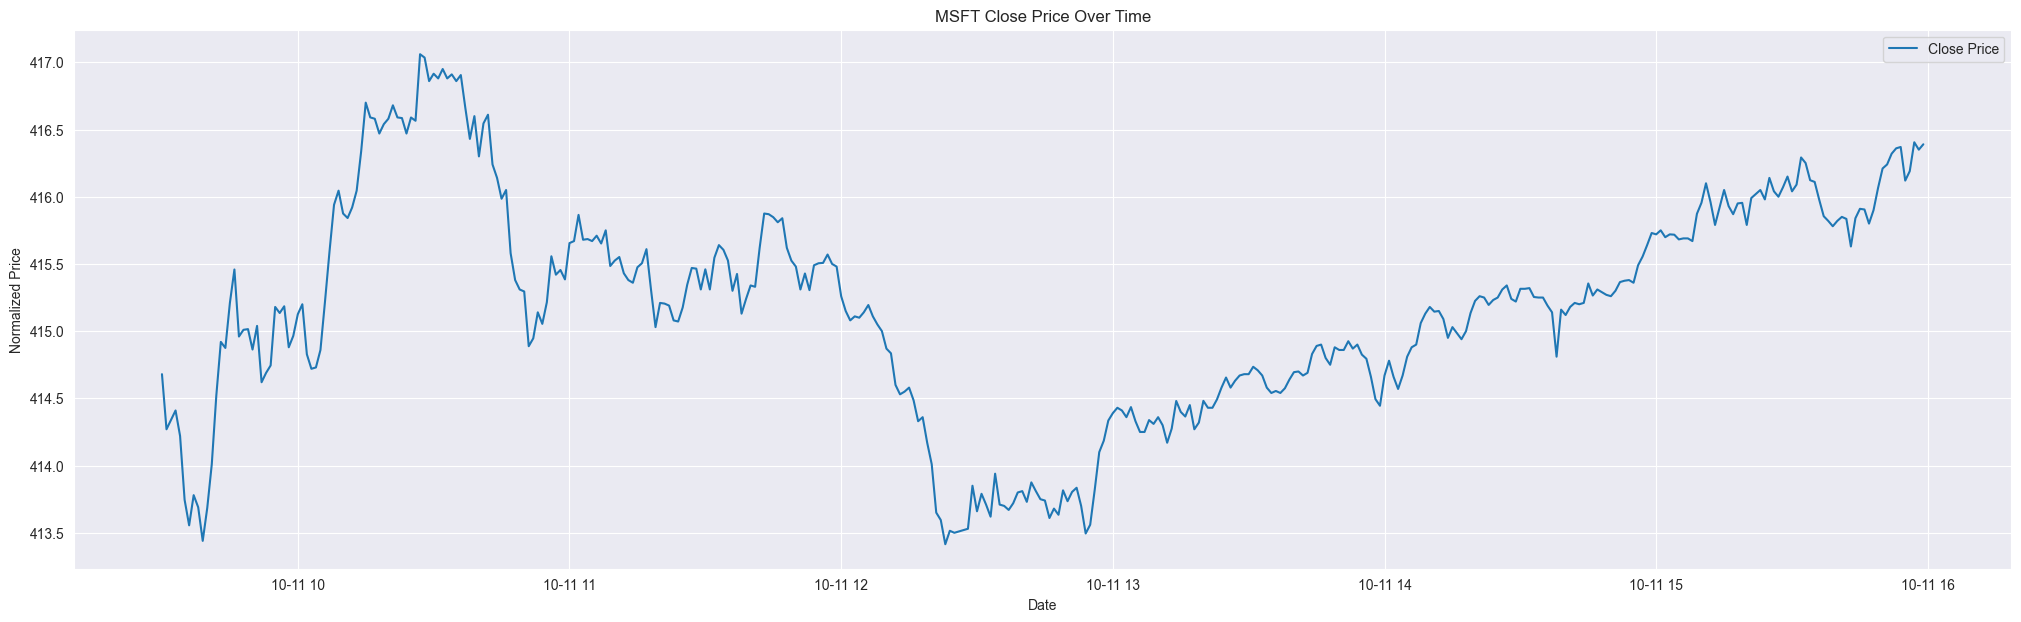

In [5]:
plt.figure(figsize=(25, 7))
plt.plot(data["Close"], label="Close Price")
plt.title("MSFT Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

This represent the Close Price of the stock market. The task is to visualize the basic stock data.

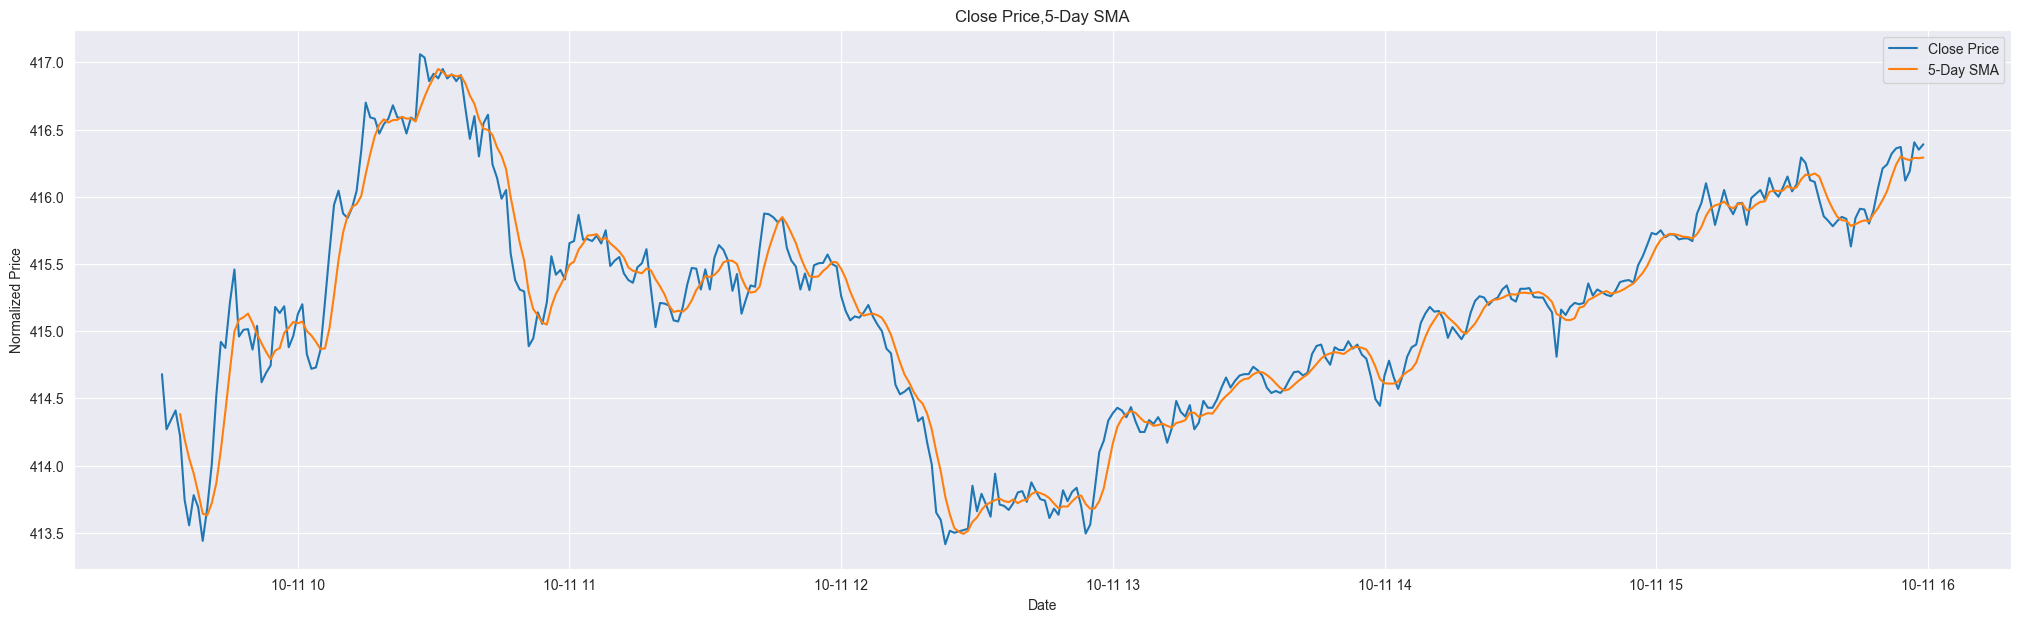

In [6]:
# Plot SMA
plt.figure(figsize=(25, 7))

plt.plot(data["Close"], label="Close Price")
plt.plot(data["SMA_5"], label="5-Day SMA")

plt.title("Close Price,5-Day SMA")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

The SMA (Simple Moving Average) is a technical indicator that shows the average price of a stock over a period of time. The SMA is calculated by adding the closing prices of the stock for a period of time and then dividing by the number of days in that period. The SMA is used to identify trends in the stock market and to help traders make decisions about when to buy or sell a stock.

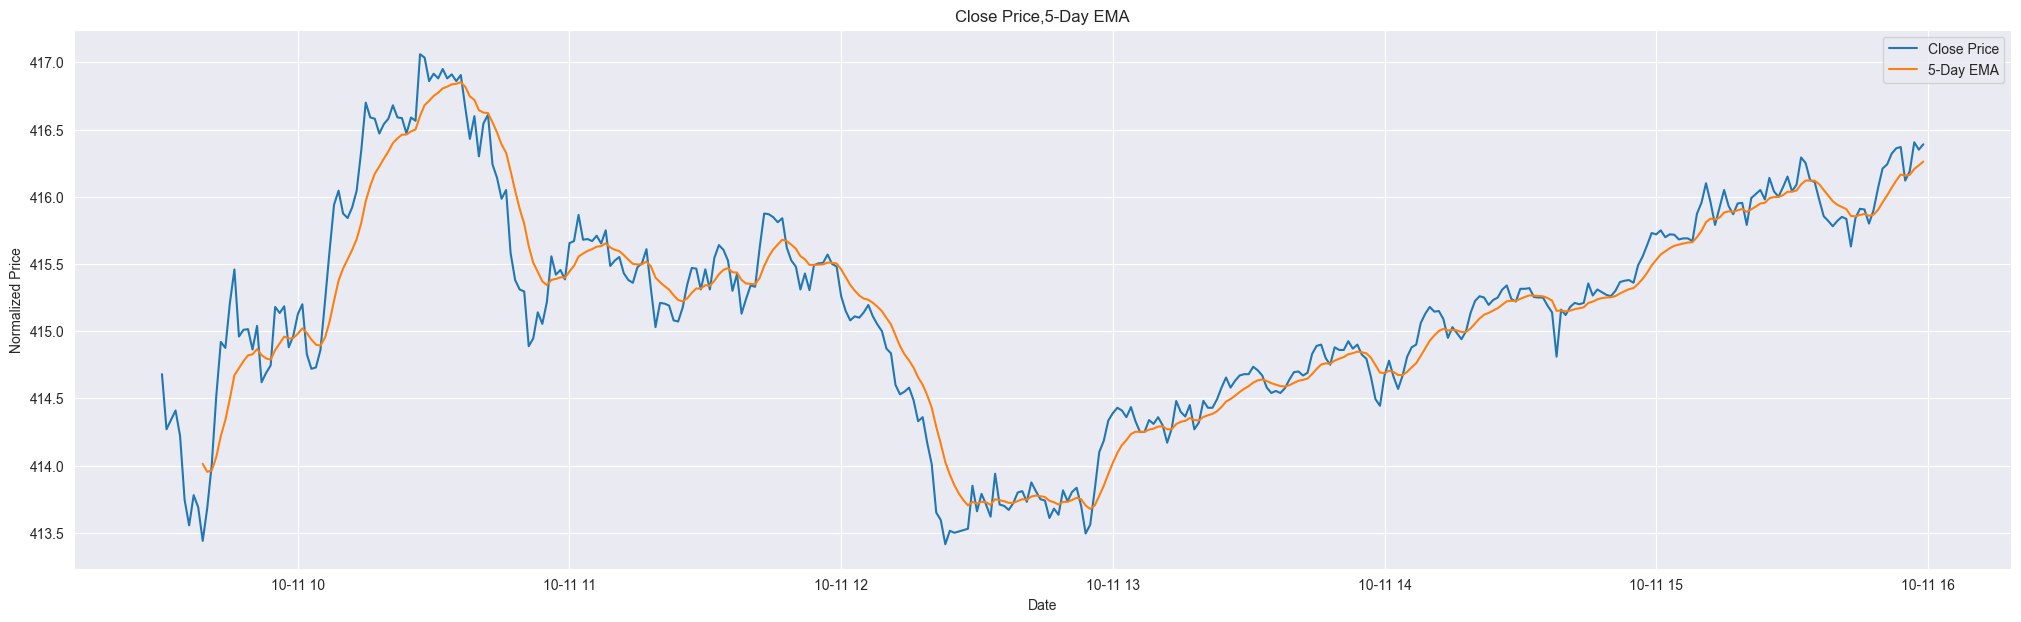

In [7]:
# Plot EMA
plt.figure(figsize=(25, 7))

plt.plot(data["Close"], label="Close Price")
plt.plot(data["EMA"], label="5-Day EMA")

plt.title("Close Price,5-Day EMA")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

The EMA (Exponential Moving Average) is a technical indicator that is similar to the SMA, but it gives more weight to the most recent prices. The EMA is calculated by taking the closing prices of the stock for a period of time and then multiplying them by a weight factor that decreases over time. The EMA is used to identify trends in the stock market and to help traders make decisions about when to buy or sell a stock.

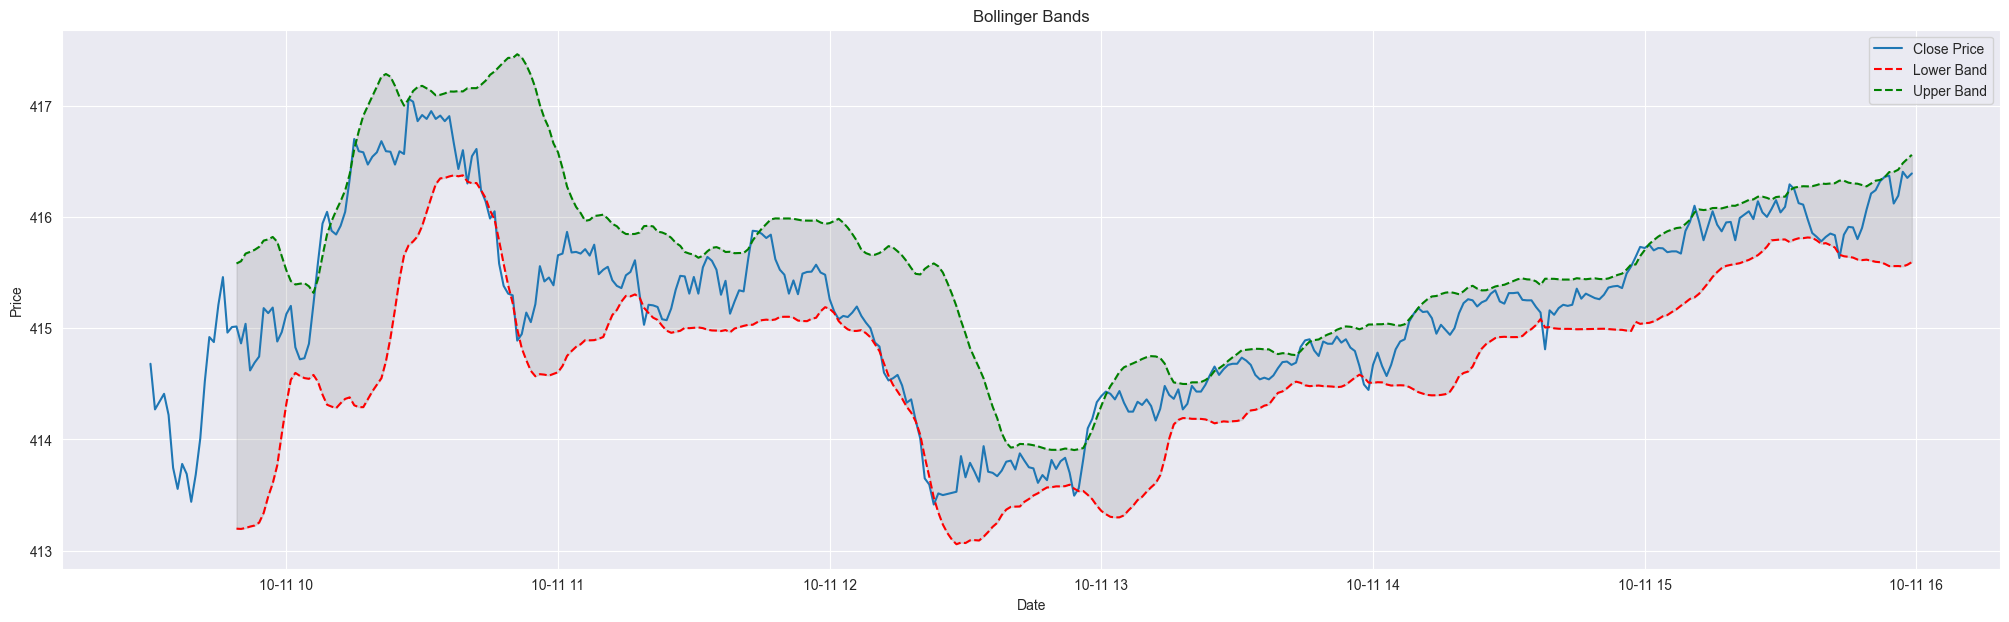

In [8]:
# Bollinger Bands
plt.figure(figsize=(25, 7))

plt.fill_between(
    data.index,
    data["BollingerB_Lower"],
    data["BollingerB_Upper"],
    color="gray",
    alpha=0.2, 
)
plt.plot(data["Close"], label="Close Price")
plt.plot(data["BollingerB_Lower"], linestyle="--", color="red", label="Lower Band")
plt.plot(data["BollingerB_Upper"], linestyle="--", color="green", label="Upper Band")

plt.title("Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

The Bollinger Bands are a technical indicator that shows the volatility of a stock. The Bollinger Bands are calculated by taking the SMA of the stock and then adding and subtracting a multiple of the standard deviation of the stock. The Bollinger Bands are used to identify when a stock is overbought or oversold and to help traders make decisions about when to buy or sell a stock.

In [24]:
result = run_back_test(
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    initial_cash = initial_cash,
    transaction_cost = 0.001,
    leverage = 1,
    stop_loss_pct = 0.05,
    take_profit_pct = 0.05,
    slippage_pct = 0.0005,
    interval = interval,
)

Running back tests for MSFT from 2024-10-11 09:30:00 to 2024-10-11 16:00:00...
Percentage Return: 10358.31%
Max Drawdown: -2.86%
Sharpe Ratio: 0.13
Sortino Ratio: 5.42
Transaction History:
2024-10-11 09:30:00-04:00: open short 5 at $414.68 P&L: 
2024-10-11 09:45:00-04:00: close short 5 at $415.42 P&L: -3.6880188751220544
2024-10-11 10:07:00-04:00: open short 5 at $415.59 P&L: 
2024-10-11 10:10:00-04:00: open long 5 at $415.88 P&L: 
2024-10-11 10:12:00-04:00: open short 5 at $415.92 P&L: 
2024-10-11 10:15:00-04:00: open short 5 at $416.70 P&L: 
2024-10-11 10:16:00-04:00: open long 5 at $416.59 P&L: 
2024-10-11 10:27:00-04:00: open short 5 at $417.06 P&L: 
2024-10-11 10:28:00-04:00: open long 5 at $417.04 P&L: 
2024-10-11 10:37:00-04:00: close long 5 at $416.45 P&L: -2.9166500091551484
2024-10-11 10:40:00-04:00: open long 5 at $416.30 P&L: 
2024-10-11 10:41:00-04:00: open short 5 at $416.55 P&L: 
2024-10-11 10:44:00-04:00: open long 5 at $416.14 P&L: 
2024-10-11 10:46:00-04:00: open shor

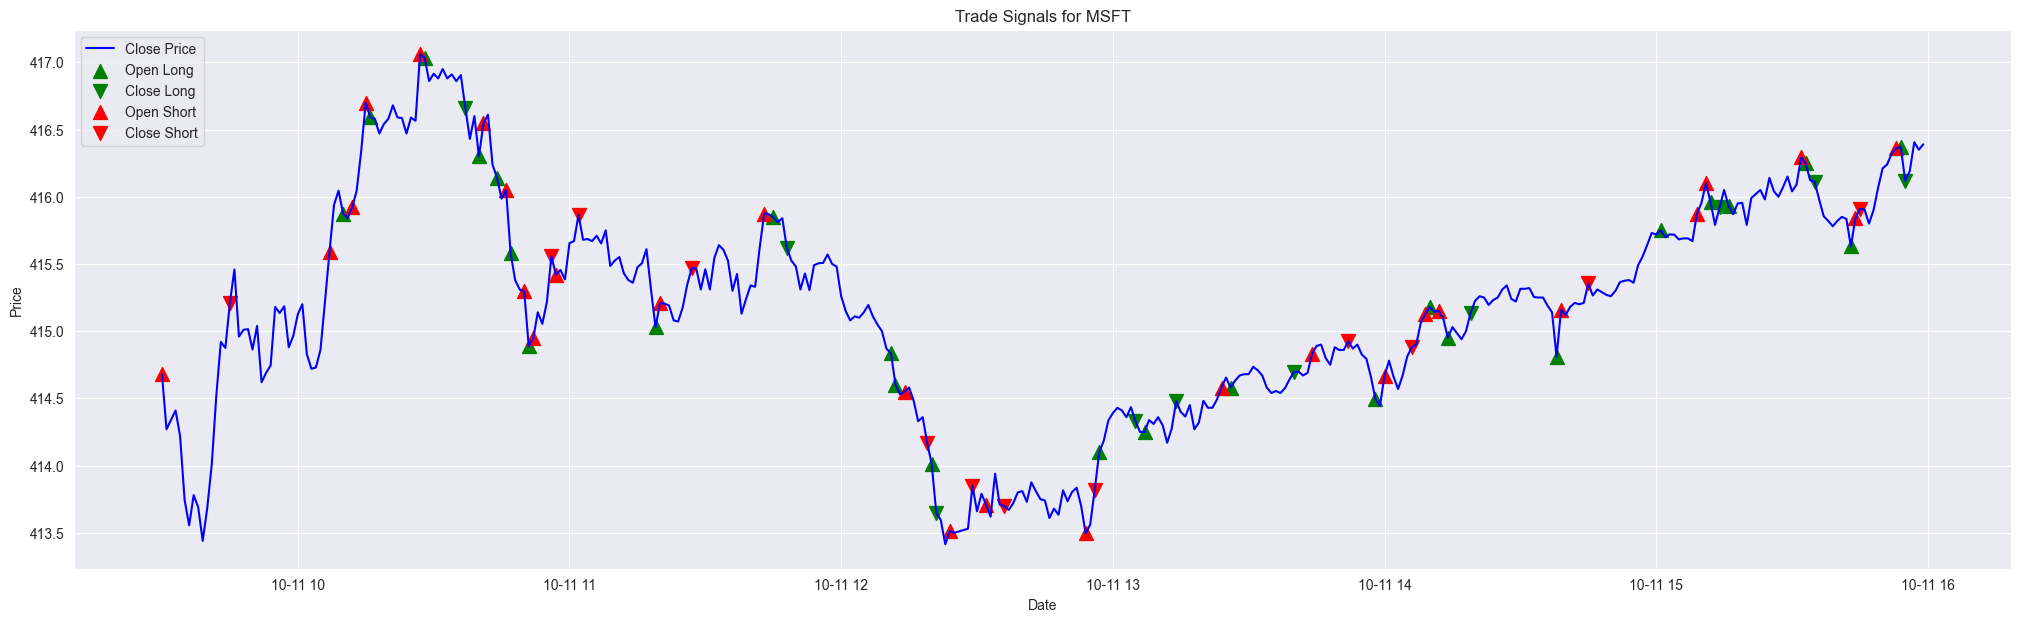

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Récupérer l'historique des transactions
transactions = result["transactions"]

# Convertir en DataFrame
transactions_df = pd.DataFrame(transactions)

# S'assurer que la colonne 'date' est de type datetime
transactions_df["date"] = pd.to_datetime(transactions_df["date"])

# Définir 'date' comme index
transactions_df.set_index("date", inplace=True)

# Filtrer les transactions
open_long = transactions_df[
    (transactions_df["action"] == "open") & (transactions_df["position_type"] == "long")
]
close_long = transactions_df[
    (transactions_df["action"] == "close")
    & (transactions_df["position_type"] == "long")
]
open_short = transactions_df[
    (transactions_df["action"] == "open")
    & (transactions_df["position_type"] == "short")
]
close_short = transactions_df[
    (transactions_df["action"] == "close")
    & (transactions_df["position_type"] == "short")
]

# Récupérer les prix de clôture
price_data = result["signals"]

plt.figure(figsize=(25, 7))

# Afficher le prix de clôture
plt.plot(price_data["Close"], label="Close Price", color="blue")

# Afficher les signaux d'ouverture de positions longues
plt.scatter(
    open_long.index,
    price_data.loc[open_long.index, "Close"],
    marker="^",
    color="green",
    label="Open Long",
    s=100,
)

# Afficher les signaux de fermeture de positions longues
plt.scatter(
    close_long.index,
    price_data.loc[close_long.index, "Close"],
    marker="v",
    color="green",
    label="Close Long",
    s=100,
)

# Afficher les signaux d'ouverture de positions courtes
plt.scatter(
    open_short.index,
    price_data.loc[open_short.index, "Close"],
    marker="^",
    color="red",
    label="Open Short",
    s=100,
)

# Afficher les signaux de fermeture de positions courtes
plt.scatter(
    close_short.index,
    price_data.loc[close_short.index, "Close"],
    marker="v",
    color="red",
    label="Close Short",
    s=100,
)

# Ajouter les labels et le titre
plt.title(f"Trade Signals for {ticker}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()